<h1 style="white-space: nowrap"> ADA - Project Milestone 2</h1>
<h2 style="white-space: nowrap;margin:22px">  Initial Data Analysis and Investigation </h2>
<hr style="clear:both">
<p style="font-size:1em; margin:2px; text-align:justify">
This Colab notebook is aimed at investigating the QuoteBank database provided in the course of Applied Data Analysis by Professor Robert West. The data consists of quotes from newspapers dated from 2015 to 2020 included.
</p>
<p style="font-size:0.95em; margin:0px"><b>Authors</b>: 
    <a href="mailto:lucas.brunschwig@epfl.ch"> Lucas Brunschwig</a>, 
    <a href="mailto:ioannis.mavrothalassitis@epfl.ch"> Ioannis Mavrothalassitis</a>, 
    <a href="mailto:axelle.piguet@epfl.ch"> Axelle Piguet</a>, 
    <a href="mailto:ester.simkova@epfl.ch"> Ester Simkova</a>

</p>
<p style="font-size:0.95em; margin:0px"><b>The data can be found</b>:
    <a href="https://zenodo.org/record/4277311#.YY0c_2DMJPY">here</a>.
</p>

<p>
    <b>Last modification</b>: 12.11.2021 
</p>

<hr/>


<b><u>Index Table</u></b>

0. Loading
  
  0.1. Libraries

  0.2. Data

1. Data Exploration
  
  1.1 Data processing

  1.2 Data visualising
  
  1.3 Removal of common english words


2. Building of the LDA Model to find hot topics

<hr/>

# 0. Loading



In [1]:
# Downgrade pandas to use chunk and avoid RAM saturation
!pip install pandas==1.0.5 

!pip install pyLDAvis==2.1.2

## 0.1 Libraries

Here we mount our drive so that we don't have to load the data locally each time we would like to work on the notebook. Each of us loaded the data in the same path so that we can automatically charge our directory.

In [2]:
# mount the google drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Common path for the adaventurers
%cd drive/My\ Drive/Colab\ Notebooks/ADA\ Project\

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/ADA Project


Warning: you might need to reload the environment because of the pandas downgrading!

In [3]:
##################### IMPORTS #####################

# NumPy to use arrays
import numpy as np
# DataFrame 
import pandas as pd
# Data Decompression
import bz2
import json

# Useful for chronological ordering
from datetime import datetime, date ,time 
import string

# Exploratory Analysis
from wordcloud import WordCloud , STOPWORDS 

# Plotting
import matplotlib.pyplot as plt

#To do initial data handling
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim.corpora as corpora

from pprint import pprint

import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

# Save Data in cache                # could load the data in the cache, to test later
#!pip install cache-magic
#import cache_magic
#!mkdir .cache
#!ln -s '/drive/My\ Drive/Colab\ Notebooks/Quotebank2/.cache' /content/.cache

#################################################

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## 0.2 Data Loading

In [4]:
eps=1e-1 # precision for progression

limit = 10 # will be changed when everything is running smoothly
maximum = 10000 # hard-coded for the moment

df_reader = pd.read_json('Quotebank/quotes-2016.json.bz2', lines=True, compression='bz2', chunksize= 10000) # here we only loaded the quotes from 2016, but we can simply change the year to have the others

print("Beginning: Loading of Quotes...")

for i,chunk in enumerate(df_reader):
  
  # Keep track of progression
  if(i/limit%0.1<eps):
    print(f"Loading... {i/limit*100} %")

  # Initialize the DataFrame columns with first chunk
  if i == 0:
    df_quotes = pd.DataFrame(chunk)
  else:
  # Concatenation of new chunk into the DataFrame
    df_quotes = pd.concat([df_quotes,chunk])

  # We don't want to read it all as long as we do not have the final code
  if i>=limit:
    break

print("Done Loading.")

Beginning: Loading of Quotes...
Loading... 0.0 %
Loading... 10.0 %
Loading... 20.0 %
Loading... 30.0 %
Loading... 40.0 %
Loading... 50.0 %
Loading... 60.0 %
Loading... 70.0 %
Loading... 80.0 %
Loading... 90.0 %
Loading... 100.0 %
Done Loading.


# 1. Data Exploration
<hr/>

<b>Format of a QUOTE</b>

Here, we will have a look at the shape of the data. The format of the original data-base is as follows:

* quoteID: a unique index that allow to select a quote
* quotation: the quote from beginning to end
* speakers: the most probable speakers (None, if unsure)
* qids: not sure
* date: date of parution to the miliseconds
* numOccurrences: the number of articles where the quote was mentionned
* probas: probability that different speakers said the quote
* urls: urls of articles that mentionned this quote
* phase: when was the data retrieved (not of interest to us)

<hr/>

In [5]:
print("Data Shape (rows, columns):", np.shape(df_quotes))
print("Column names as depicted above:", df_quotes.columns)
df_quotes.head(4)

Data Shape (rows, columns): (110000, 9)
Column names as depicted above: Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2016-12-26-000040,[ ] and Chris [ Jones ] were in there a lot an...,Andy Reid,"[Q2622812, Q27830815, Q470738, Q4761219]",2016-12-26 20:05:00,1,"[[Andy Reid, 0.9432], [None, 0.0541], [Trevor ...",[http://www.kcchiefs.com/news/article-2/How-a-...,E
1,2016-07-31-000006,[ And ] I don't know if we have enough time to...,Mike Howe,[Q6847325],2016-07-31 08:22:12,2,"[[Mike Howe, 0.7118], [None, 0.2882]]",[http://www.peninsuladailynews.com/apps/pbcs.d...,E
2,2016-09-06-000292,... I feel like I was champion long before I l...,None,[],2016-09-06 20:54:45,2,"[[None, 0.6877], [John Waters, 0.3123]]",[http://onlineathens.com/breaking-news/2016-09...,E
3,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,[Q6294],2016-07-11 17:26:06,1,"[[Hillary Clinton, 0.9025], [None, 0.0975]]",[http://www.breitbart.com/tech/2016/07/11/hill...,E


In [6]:
print("One typical event:")
print()
df_quotes.loc[0] # example of one row

One typical event:



quoteID                                           2016-12-26-000040
quotation         [ ] and Chris [ Jones ] were in there a lot an...
speaker                                                   Andy Reid
qids                       [Q2622812, Q27830815, Q470738, Q4761219]
date                                            2016-12-26 20:05:00
numOccurrences                                                    1
probas            [[Andy Reid, 0.9432], [None, 0.0541], [Trevor ...
urls              [http://www.kcchiefs.com/news/article-2/How-a-...
phase                                                             E
Name: 0, dtype: object

## 1.1 Data Processing

In [7]:
# code for data cleaning  

# Drop duplicated rows
df_quotes.drop_duplicates(subset="quoteID")

# Drop columns: phase and qids that are not of interest to us
df_quotes.drop(columns=['phase','qids'])

# Check if ids are unique
df_quotes.index.is_unique 

True

Sort data in chronological order. We will extract only quotes in a certain time frame. Here you can find an example of a time-frame around the US election period of 2016.

In [8]:
df_quotes.sort_values(by=['date'], inplace=True, ascending=True)

##### IMPORTANT: we take only a subset of quotes for a given time window
df_quotes = df_quotes[df_quotes.date.dt.month == 11] # The 2016 United States elections were held on Tuesday, November 8, 2016, let's look around this period
df_quotes = df_quotes[df_quotes.date.dt.day <= 12]
df_quotes = df_quotes[df_quotes.date.dt.day >= 5]
df_quotes.head()
print(np.shape(df_quotes))

(85, 9)


In [9]:
string.punctuation.replace("'",'')

'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'

Let's process the quotation column to make it uniform and easy to work with.

In [10]:
# Since we're interested in topics, let's remove punctuations that are useless for this purpose
df_quotes['quotation'] = df_quotes['quotation'].str.replace('[{}]'.format(string.punctuation),'')
# Let's also put all words in lowercase
df_quotes['quotation'] = df_quotes['quotation'].str.lower()

# Let's have a look
df_quotes['quotation'].head(4)

105118     its straight whathaveyoudoneformelately politics
87351     we dont ordinarily tell congress about ongoing...
2882      it is like the rocky road to dublin up in the ...
22657     i should say when you look back you get a bett...
Name: quotation, dtype: object

# 1.2 Data visualising
Inspired from the article [Topic Modeling in Python: LDA](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0), by Shashank Kapadia. 

The first plot is only exploratory analysis. We wanted to observe how our data looks like and see if the format was suitable. 

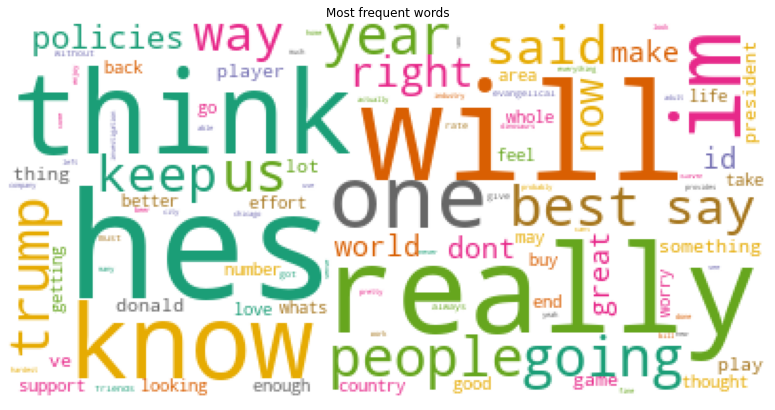

In [11]:
# Word cloud is a technique for visualising frequent words in a text where the size of the words represents their frequency.

# Define a function to plot word cloud
def plot_Wordcloud(quote_column):     
    all_text = " ".join( list(quote_column.values))
    word_cloud = WordCloud(background_color="white", max_words=100,colormap='Dark2', collocations=False, stopwords = STOPWORDS).generate(all_text)
    plt.figure(figsize=(15, 7))
    plt.imshow(word_cloud) 
    plt.axis("off")
    plt.title('Most frequent words')

# Let's create the word cloud 
plot_Wordcloud(df_quotes['quotation'])

## 1.3 Removal of common english words
Common words are not of interest to find topics. They only add noise to the data and therefore we need to remove them from the quotes. We also added the most common unwanted ones found in the exploratory analysis as well as removed all words that are not nouns nor proper nouns.

In [12]:
# Words extraction that are not nouns

def VerbExtractor(text):
  verb_list = []
  sentences = nltk.sent_tokenize(text)
  for sentence in sentences:
    words = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(words)
    for (word, tag) in tagged:
      if (tag[0] != 'N' and 'NP'): # If the word is a noun, we keep it (singular/plural/proper name)
        verb_list.append(word)
  return verb_list

In [13]:
nltk.download('punkt')

# download a list of english stop words (meaning words we don't want to consider when finding topics)
stop_words = nltk.corpus.stopwords.words('english')
text = " ".join( list(df_quotes['quotation'].values))
verb_list=VerbExtractor(text)

# extend the stop words list with the ones found in our exploratory data analyses
stop_words.extend(["like", "im", "good", "hes", "going","first","things","thing","way","someone","anyone","everything","think","people","will","need","would","dont","ive","thats","really","little","something","cant","goal","lot","well","better"]) # not extensive yet but will be updated in the near future
stop_words.extend(verb_list)

print("Common English Words", stop_words)

# Function to remove stop words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

quote = df_quotes["quotation"].values.tolist()

# remove the stop words
quote_words = remove_stopwords(quote)

# print the remaining words for an example quote
print("Quote words:", quote_words[:1][0][:30])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Common English Words ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all

# 2. Building of the LDA Model to find hot topics

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(quote_words)

# Create Corpus
texts = quote_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:10])

[]


In [15]:
# number of topics, to be manually selected
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"rate" + 0.013*"president" + 0.011*"policies" + 0.011*"player" + '
  '0.010*"peace" + 0.010*"development" + 0.010*"bill" + 0.010*"company" + '
  '0.010*"effort" + 0.010*"years"'),
 (1,
  '0.012*"women" + 0.012*"friends" + 0.011*"permission" + 0.011*"town" + '
  '0.011*"policies" + 0.008*"years" + 0.008*"culture" + 0.008*"beer" + '
  '0.007*"fun" + 0.007*"life"'),
 (2,
  '0.021*"world" + 0.012*"whats" + 0.011*"nation" + 0.011*"minnesota" + '
  '0.011*"gas" + 0.011*"students" + 0.011*"past" + 0.011*"day" + 0.010*"years" '
  '+ 0.010*"honour"')]


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [16]:
# Visualize the topics obtained with the LDA model
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('results/ldavis_prepared_'+str(num_topics)) # you need to create a "results" folder


LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

pyLDAvis.save_html(LDAvis_prepared, 'results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=             x         y  topics  cluster       Freq
topic                                               
0     -0.07010  0.026186       1        1  42.506210
2      0.01149 -0.071527       2        1  30.690855
1      0.05861  0.045341       3        1  26.802938, topic_info=           Term      Freq     Total Category  logprob  loglift
12        world  2.000000  2.000000  Default  30.0000  30.0000
219       women  1.000000  1.000000  Default  29.0000  29.0000
157  permission  1.000000  1.000000  Default  28.0000  28.0000
88         town  1.000000  1.000000  Default  27.0000  27.0000
226      nation  1.000000  1.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
123     culture  0.720282  1.630165   Topic3  -4.8463   0.4999
59         beer  0.703822  1.638765   Topic3  -4.8694   0.4715
43        years  0.776210  3.312024   Topic3  -4.7715  -0.1342
125         fun  0.640657  1.536511   Topic3  -4.9634   0.4419
34         life  0.633456  2.178816   Topic3  -4.9747   0.0813

[151 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
51        1  0.843730  accountability
222       2  0.947120        approval
68        1  0.561730           areas
119       3  0.977397          artist
120       3  0.977328           basis
...     ...       ...             ...
219       3  0.663627           women
12        2  0.770861           world
43        1  0.301930           years
43        2  0.301930           years
43        3  0.301930           years

[130 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

We can see here that for the period around the US presidential elections of 2016 and by selecting 3 topics, we have a first cluster of words that contains the words "president", "policies", "development", "country" ... that are related to these election times. The second and third clusters however are harder to interpret in terms of certain events happening.

Indeed, since we have many quotes from many different speakers/newspapers, it is a hard task to find events emerging from quotes since everybody talks about something else.